In [1]:
import numpy as np
import pickle
import time

from src.data.make_dataset import generate_dataset
from src.models.train_model import BO_loop, grid_search, dist_loop
from src.models.acquisition import Random, MaxVariance

from functools import partial

In [2]:
# run trig basis tests
iters = 5
rng = np.random.default_rng(seed = 42)
data_seeds = rng.integers(low=0, high=10000, size=iters)

ds_cfg = {'n_cpts': 5, 'supply_truth':False, 'basis':'trig'}
bo_cfg = {'pca_cpts': 4, 'bo_iters':200}

mv_bo_loop = partial(BO_loop, acq_func=MaxVariance )
mv_bo_loop.__name__='mv_bo_loop'
rand_bo_loop = partial(BO_loop, acq_func=Random )
rand_bo_loop.__name__='rand_bo_loop'
loops = [grid_search, dist_loop, mv_bo_loop, rand_bo_loop]

In [18]:
for s in data_seeds:
    face_image, data, x_vals = generate_dataset(n_cpts=ds_cfg['n_cpts'], 
                                seed=s, supply_truth=ds_cfg['supply_truth'],
                                xanes=ds_cfg['basis'])
    for loop in [mv_bo_loop]:
        # run test
        ts = time.time()
        _, varis, errs, info_dict = loop(data, n_cpts=bo_cfg['pca_cpts'], 
                                        n_iters=bo_cfg['bo_iters'])

        # construct results dictionary and save
        results = {'max_variances': varis,
                    'errors': errs,
                    'info_dict': info_dict,
                    'bo_cfg': bo_cfg,
                    'ds_cfg': ds_cfg,
                    'loop_type': loop.__name__,
                    'start_time': ts
                    }
        break

        # with open(f'results_{ds_cfg["basis"]}_{s}_{loop.__name__}.pkl', 'wb') as f:
        #     pickle.dump(results, f)    
    break

=== iter 0, ((10, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 1, ((11, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 2, ((12, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 3, ((13, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 4, ((14, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 5, ((15, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 6, ((16, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 7, ((17, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 8, ((18, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 9, ((19, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 10, ((20, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 11, ((21, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 12, ((22, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 13, ((23, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 14, ((24, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 15, ((25, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 16, ((26, 4)) -- cpt 0 --

Iter 10/2000: 0.6835506558418274
Iter 20/2000: 0.6473759412765503


(<Figure size 504x504 with 4 Axes>,
 array([[<AxesSubplot:xlabel='iter', ylabel='max variance'>,
         <AxesSubplot:xlabel='iter', ylabel='Mean squared error'>],
        [<AxesSubplot:title={'center':'ground truth'}>,
         <AxesSubplot:title={'center':'mean'}>]], dtype=object))

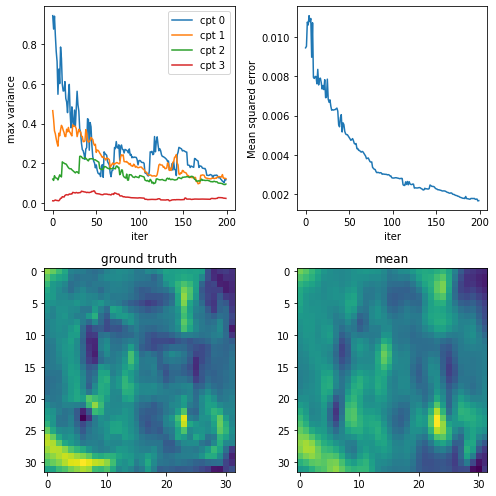

In [19]:
plot_component_comp(data, info_dict['curr_cpt_weights'], 
                torch.Tensor(info_dict['train_x']), info_dict['test_x'], 
                varis, errs['spec_mse_avg'])

In [3]:
# reading and coallating data
from pathlib import Path
pkl_path = Path.cwd().parent / 'reports' / 'results_xanes_400'
print(pkl_path)


c:\Users\roberttk\Desktop\SLAC_RA\machine-learning\ls_be\reports\results_xanes_400


In [4]:

newdist = {n.__name__:[] for n in loops}
for p in (pkl_path.parent / 'results_newdist_400').glob('*.pkl'):
    with open(p, 'rb') as f:
        a = pickle.load(f)
    newdist[a['loop_type']].append(a['errors']['spec_mse_avg'])

In [5]:
spec_mse_err = {n.__name__:[] for n in loops}
for p in pkl_path.glob('*.pkl'):
    with open(p, 'rb') as f:
        a = pickle.load(f)
    spec_mse_err[a['loop_type']].append(a['errors']['spec_mse_avg'])

statistics over 40 tests


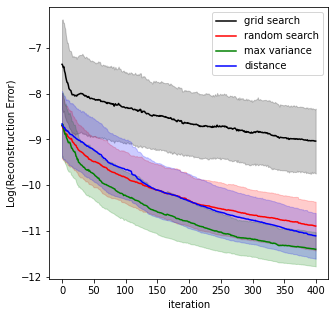

In [6]:
plt.figure(figsize=(5,5))
new_name = {'grid_search': 'grid search', 'mv_bo_loop': 'max variance', 
            'rand_bo_loop': 'random search', 'dist_loop': 'distance' }

color_code = ['k', 'r', 'b', 'g']
for i, loop_name in enumerate(['grid_search', 'rand_bo_loop', 'dist_loop', 'mv_bo_loop']):
    if loop_name == 'dist_loop':
        continue

    arr = np.array(spec_mse_err[loop_name])
    mean = np.mean(arr, axis=0).flatten()
    std = np.std(np.log(arr), axis=0).flatten()

    plt.plot(np.log(mean), color_code[i], label=new_name[loop_name])
    # plt.plot(arr.T)
    plt.fill_between(range(len(mean)), np.log(mean)-std, 
                    np.log(mean)+std, color=color_code[i], alpha=0.2)

arr = np.array(newdist['dist_loop'])
mean = np.mean(arr, axis=0).flatten()
std = np.std(np.log(arr), axis=0).flatten()

plt.plot(np.log(mean), 'b', label='distance' )
plt.fill_between(range(len(mean)), np.log(mean)-std, np.log(mean)+std, color='b', alpha=0.2)


plt.legend()
# plt.ylim(0.000005, 0.001)
plt.ylabel('Log(Reconstruction Error)')
plt.xlabel('iteration')
print(f'statistics over {arr.shape[0]} tests')
plt.savefig('xanes_recon_err.png')

In [10]:
np.shape(spec_mse_err['grid_search'])

(30, 400)

c:\Users\roberttk\Desktop\SLAC_RA\machine-learning\ls_be\reports\results_trig_400\results_trig_3670_dist_loop.pkl
3670
Iter 10/2000: 0.3550422489643097
Iter 20/2000: 0.3241519033908844
Iter 30/2000: 0.3084942698478699
Iter 40/2000: 0.30387988686561584


(<Figure size 504x504 with 4 Axes>,
 array([[<AxesSubplot:xlabel='iter', ylabel='max variance'>,
         <AxesSubplot:xlabel='iter', ylabel='Mean squared error'>],
        [<AxesSubplot:title={'center':'ground truth'}>,
         <AxesSubplot:title={'center':'mean'}>]], dtype=object))

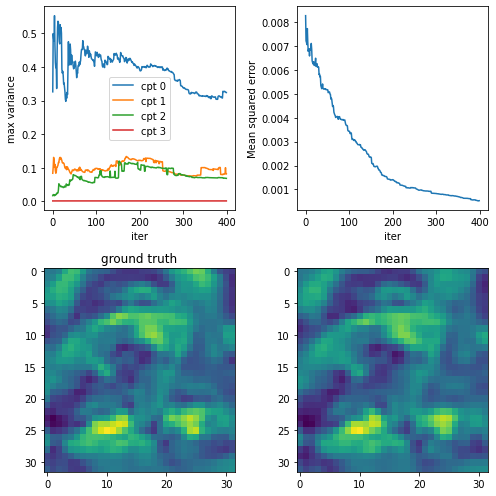

In [11]:
from src.visualization.visualize import plot_component_comp
import torch
import re

pickle_list = list(pkl_path.glob('*.pkl'))
i=40
fp = pickle_list[i]
with open(fp, 'rb') as f:
    print(fp)
    a = pickle.load(f)

# grab numbers
s = int(re.search('\d+',fp.name).group())
print(s)

face_image, data, x_vals = generate_dataset(n_cpts=a['ds_cfg']['n_cpts'], 
                            seed=s, supply_truth=a['ds_cfg']['supply_truth'],
                            xanes='trig')

plot_component_comp(data, a['info_dict']['curr_cpt_weights'], 
                torch.Tensor(a['info_dict']['train_x']), a['info_dict']['test_x'], 
                a['max_variances'], a['errors']['spec_mse_avg'])

In [13]:
xanes = 'xanes'

if (xanes is None) or (xanes == 'xanes'):
    print('xanes detected')
if xanes == 'trig':
    print('trig detected')


xanes detected
